In [2]:
# Load modules
import sys
sys.path.append('../utilities_tlezuo/')

import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
from wrf import getvar, interp1d
from netCDF4 import Dataset

from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import datetime as dt

from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
###############################################################################################
## CONSTANT FILE  ##
c_filename = "lfff00000000c.nc"
filepath = '/store/s83/swester/teamx/tdf_2019091212/output/19091212/'
const_file = filepath + c_filename
data_c = psy.open_dataset(const_file)

###############################################################################################
## DECIDE ##
# where to save
loadpath = '/users/tlezuo/icon-vis/height_time_diagrams/data/'
# decide which locations to calculate
loc_list = []
# loc_list.extend([])
loc_list=[lf.kols]

# decide which variables to calculate
pvars_list = []
# pvars_list.extend([vf.qv_2m,vf.T_2M])
pvars_list= [vf.U, vf.V, vf.T,vf.TH,vf.QV,vf.P,vf.VEL,vf.DIR]

###############################################################################################
## DATELISTS ##
# ICON model: as writeout times: 30 min
startdate_model = dt.datetime(2019,9,12,12,00)
enddate_model = dt.datetime(2019,9,14,00,00)
plotdates_model = pd.date_range(startdate_model,enddate_model,freq='0h30min')
plotdates_model_list = list(plotdates_model)
# radiosoundings: 3h and 2h intervals
plotdates_rs = [dt.datetime(2019,9,12,23,00),dt.datetime(2019,9,13,3,00),dt.datetime(2019,9,13,6,00),dt.datetime(2019,9,13,9,00),
dt.datetime(2019,9,13,11,00),dt.datetime(2019,9,13,13,00),dt.datetime(2019,9,13,15,00),dt.datetime(2019,9,13,17,00),dt.datetime(2019,9,13,20,00),dt.datetime(2019,9,13,23,00)]
# radiosoundings Munich: 00+12
plotdates_murs = [dt.datetime(2019,9,12,12,00),dt.datetime(2019,9,13,0,00),dt.datetime(2019,9,13,12,00),dt.datetime(2019,9,14,0,00)]
# lidar SR88: 10 min
plotdates_lidar = pd.date_range(startdate_model,enddate_model,freq='0h10min')

In [4]:
## LOAD DATA ##
# ICON model
htd_data_model = {}
htd_data_model['kols'] = np.load(loadpath+'htd_ICON_kols.npy',allow_pickle='TRUE').item()
htd_data_model['murs'] = np.load(loadpath+'htd_ICON_murs.npy',allow_pickle='TRUE').item()
htd_data_model['ifl'] = np.load(loadpath+'htd_ICON_ifl.npy',allow_pickle='TRUE').item()

# Streamline Lidar SR88
htd_data_lidar_SL88 = xr.open_dataset(loadpath+'htd_lidar_SL88_Kolsass.nc').load()
htd_data_lidar_SL88 = htd_data_lidar_SL88.transpose()
# Streamline Lidar SLXR142
htd_data_lidar_SLXR142 = xr.open_dataset(loadpath+'htd_lidar_SLXR142_Kolsass.nc').load()
# HATPRO Lidar
htd_data_lidar_hatpro = xr.open_dataset(loadpath+'htd_lidar_hatpro_Kolsass.nc').load()
htd_data_lidar_hatpro = htd_data_lidar_hatpro.transpose()

# Kolsass radiosoundings
htd_data_kolsrs = np.load(loadpath+'htd_rs_Kolsass.npy',allow_pickle='TRUE').item()
htd_data_kolsrs_interp = np.load(loadpath+'htd_rs_interp_Kolsass.npy',allow_pickle='TRUE').item()
# Munich radiosounding
htd_data_murs = np.load(loadpath+'htd_rs_Munich.npy',allow_pickle='TRUE').item()
htd_data_murs_interp = np.load(loadpath+'htd_rs_interp_Munich.npy',allow_pickle='TRUE').item()
# Innsbruck radiosounding
htd_data_iflrs = np.load(loadpath+'htd_rs_Innsbruck.npy',allow_pickle='TRUE').item()
htd_data_iflrs_interp = np.load(loadpath+'htd_rs_interp_Innsbruck.npy',allow_pickle='TRUE').item()

In [5]:
def get_sounding(pvar,pdate,loc):
    # model levels
    lev_model = htd_data_model[loc.short]['HFL_loc']
    lev_model_cut = lev_model[0:73]

    # indices for model
    ti_model = plotdates_model_list.index(pdate)

    # get data model
    sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])
    sounding_model_cut = sounding_model[0:73]       

    if pdate.strftime('%H') == '02': # if 02 -> we want to see ifl sounding
        # index for rs Innsbruck is always 0
        ti_rs = 0
        sounding_rs_interp = np.array(htd_data_iflrs_interp[pvar.name][ti_rs,:])
    
    elif pdate.strftime('%H') == '12' or pdate.strftime('%H') ==  '00': # if 12 or 00 -> we want to see murs sounding
        # index for rs Munich
        ti_rs = plotdates_murs.index(pdate)
        sounding_rs_interp = np.array(htd_data_murs_interp[pvar.name][ti_rs,:])
    
    else: # else -> we want Kolsass/CROSSINN sounding
        # index for rs Kolsass
        ti_rs = plotdates_rs.index(pdate)
        sounding_rs_interp = np.array(htd_data_kolsrs_interp[pvar.name][ti_rs,:])

    return lev_model_cut,sounding_model_cut,sounding_rs_interp,ti_model,ti_rs

def plot_sounding(pvar, pdate, loc, axis):

    lev_model_cut,sounding_model_cut,sounding_rs_interp,ti_model,ti_rs = get_sounding(pvar,pdate,loc)                                                                                          
    # plot it
    m = axis.plot(sounding_model_cut,  lev_model_cut, lw=2,color='dodgerblue',label='ICON')
    r = axis.plot(sounding_rs_interp,  lev_model_cut, lw=2,color='darkviolet',label='observations')
    
    # fill between to highlight bias
    axis.fill_betweenx(lev_model_cut, sounding_model_cut, sounding_rs_interp, where=(sounding_model_cut > sounding_rs_interp), alpha=0.2, color='orangered')
    axis.fill_betweenx(lev_model_cut, sounding_model_cut, sounding_rs_interp, where=(sounding_model_cut < sounding_rs_interp), alpha=0.2, color='cyan')

    # title
    axis.set_title(pdate.strftime('%H:%M'), fontsize=12)
    
    # windbarbs
    if pvar.name == 'VEL':
        q_scale = 30
        q_width = 0.002
        lev_model_cut,U_model,U_rs,ti_model,ti_rs = get_sounding(vf.U,pdate,loc)
        lev_model_cut,V_model,V_rs,ti_model,ti_rs = get_sounding(vf.V,pdate,loc)
        axis.quiver(np.full(73,20), lev_model_cut, U_model, V_model, 
            scale=q_scale, scale_units='inches', width=q_width,color='dodgerblue')
        axis.quiver(np.full(73,15), lev_model_cut, U_rs,V_rs, 
            scale=q_scale, scale_units='inches', width=q_width,color='darkviolet')


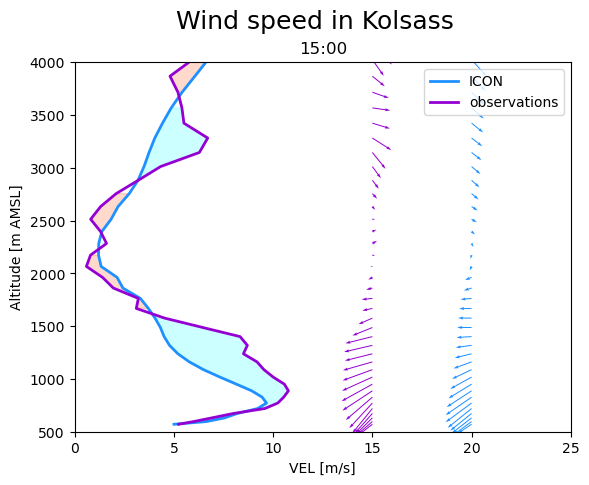

In [6]:
## PLOT SINGLE PROFILE ##
# general settings
pvar = vf.VEL
loc= lf.kols
pdate = dt.datetime(2019,9,13,15,00) # only at rs times

# plotsettings
xmin=0
xmax=25
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
plot_sounding(pvar, pdate, loc, ax)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

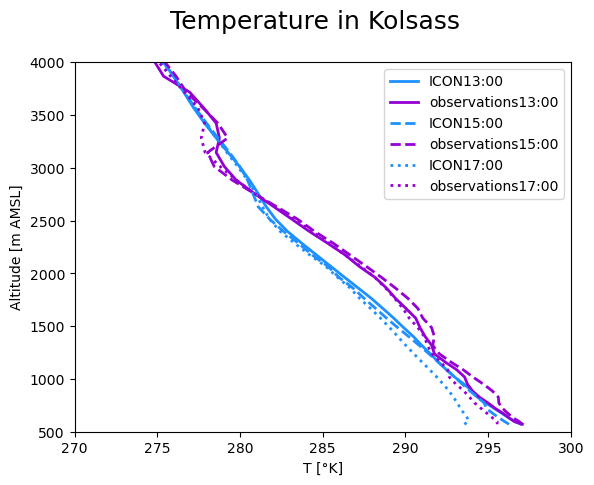

In [7]:
## PLOT MULTIPLE PROFILES of Kolsass in 1 PLOT ##
# general settings
pvar = vf.T
pdate1 = dt.datetime(2019,9,13,13,00)
loc1= lf.kols
pdate2 = dt.datetime(2019,9,13,15,00)
loc2= lf.kols
pdate3 = dt.datetime(2019,9,13,17,00)
loc3= lf.kols

# plotsettings
xmin=270
xmax=300
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# first time
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1) 
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label='ICON'+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label='observations'+pdate1.strftime('%H:%M'))
# second time
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc2) 
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label='ICON'+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label='observations'+pdate2.strftime('%H:%M'))
# # third time
lev_model_cut,sounding_model_cut3,sounding_rs_interp3,ti_model3,ti_rs3 = get_sounding(pvar,pdate3,loc3) 
m3 = ax.plot(sounding_model_cut3,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dotted',label='ICON'+pdate3.strftime('%H:%M'))
r3 = ax.plot(sounding_rs_interp3,  lev_model_cut, lw=2,color='darkviolet',linestyle='dotted',label='observations'+pdate3.strftime('%H:%M'))
                                                                                                                                                                          
# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

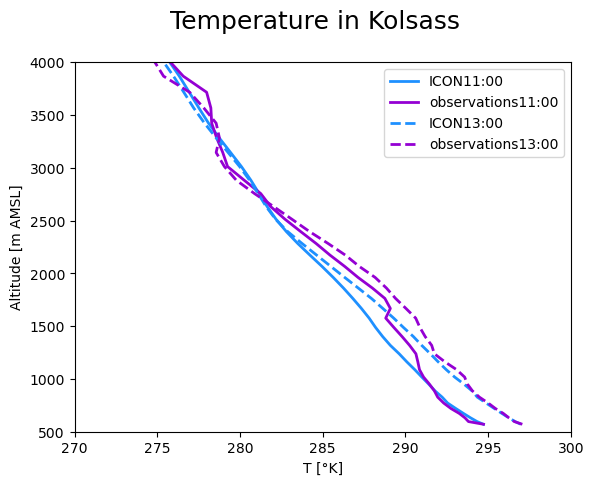

In [8]:
## PLOT MULTIPLE PROFILES of Kolsass in 1 PLOT ##
# general settings
pvar = vf.T
pdate1 = dt.datetime(2019,9,13,11,00)
loc1= lf.kols
pdate2 = dt.datetime(2019,9,13,13,00)
loc2= lf.kols
# pdate3 = dt.datetime(2019,9,13,17,00)
# loc3= lf.kols

# plotsettings
xmin=270
xmax=300
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# first time
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1) 
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label='ICON'+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label='observations'+pdate1.strftime('%H:%M'))
# second time
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc2) 
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label='ICON'+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label='observations'+pdate2.strftime('%H:%M'))
# # third time
# lev_model_cut,sounding_model_cut3,sounding_rs_interp3,ti_model3,ti_rs3 = get_sounding(pvar,pdate3,loc3) 
# m3 = ax.plot(sounding_model_cut3,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dotted',label='ICON'+pdate3.strftime('%H:%M'))
# r3 = ax.plot(sounding_rs_interp3,  lev_model_cut, lw=2,color='darkviolet',linestyle='dotted',label='observations'+pdate3.strftime('%H:%M'))
                                                                                                                                                                          
# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

/tmp/ipykernel_231227/4170451258.py:11: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])
/tmp/ipykernel_231227/1880423380.py:20: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc1.short][pvar.name][ti_model3,:])


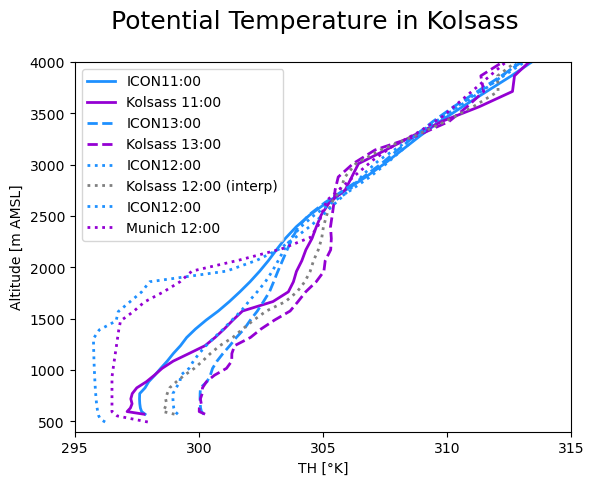

In [26]:
## TIME INTERPOLATION ##
pvar = vf.TH

# interpolate Kolsass rs to 12 UTC to compare with Munich
pdate1 = dt.datetime(2019,9,13,11,00)
pdate2 = dt.datetime(2019,9,13,13,00)
pdate3 = dt.datetime(2019,9,13,12,00)
loc1= lf.kols

# get rs and model data at 11 and 13 UTC in Kolsass
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1)
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc1)  
# interpolate
sounding_rs_interp3kols_i= (sounding_rs_interp1+sounding_rs_interp2)/2

# get rs and model data at 12 in Munich
loc2= lf.murs
lev_model_cut_murs,sounding_model_cut3murs,sounding_rs_interp3murs,ti_model3,ti_rs3 = get_sounding(pvar,pdate3,loc2) 
# get model data in Kolsass at 12 UTC
sounding_model = np.array(htd_data_model[loc1.short][pvar.name][ti_model3,:])
sounding_model_cut3kols = sounding_model[0:73]

## PLOT ##
# plotsettings 
xmin=295
xmax=315
ymin=400
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# first time Kolsass
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label='ICON'+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label='Kolsass '+pdate1.strftime('%H:%M'))
# second time Kolsass
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label='ICON'+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label='Kolsass '+pdate2.strftime('%H:%M'))
# interp time Kolsass
m3 = ax.plot(sounding_model_cut3kols,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dotted',label='ICON'+pdate3.strftime('%H:%M'))
r3 = ax.plot(sounding_rs_interp3kols_i,  lev_model_cut, lw=2,color='grey',linestyle='dotted',label='Kolsass '+pdate3.strftime('%H:%M')+' (interp)')
# interp time Munich
m3 = ax.plot(sounding_model_cut3murs,  lev_model_cut_murs, lw=2,color='dodgerblue',linestyle='dotted',label='ICON'+pdate3.strftime('%H:%M'))
r3 = ax.plot(sounding_rs_interp3murs,  lev_model_cut_murs, lw=2,color='darkviolet',linestyle='dotted',label='Munich '+pdate3.strftime('%H:%M'))

# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin+100,ymax+101,500))
plt.legend()

plt.show()

/tmp/ipykernel_231227/4170451258.py:11: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])
/tmp/ipykernel_231227/4170451258.py:11: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])


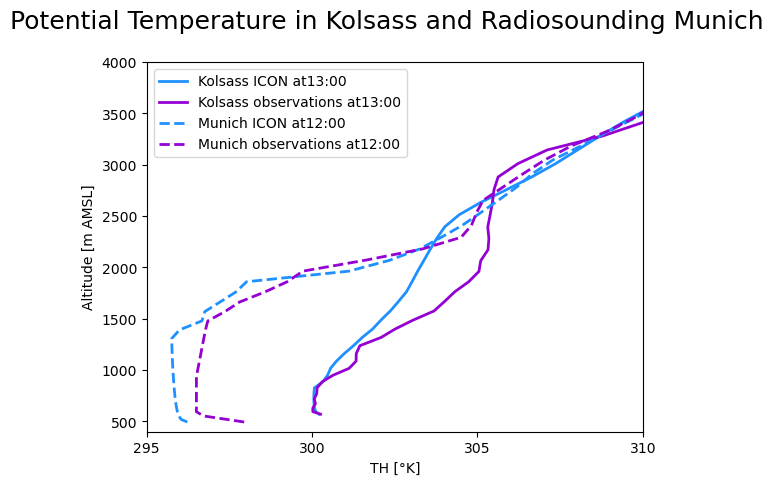

In [9]:
## COMPARE VALLEY AND PLAIN ##
# general settings
pvar = vf.TH

pdate1 = dt.datetime(2019,9,13,13,00)
loc1= lf.kols
pdate2 = dt.datetime(2019,9,13,12,00)
loc2= lf.murs

# plotsettings
xmin=295
xmax=310
ymin=400
ymax=4000
xdelticks=5

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc1.name + ' and ' +loc2.name  , fontsize=18, y=0.99)
# first time
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1) 
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label='Kolsass ICON at'+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label='Kolsass observations at'+pdate1.strftime('%H:%M'))
# second time
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc2) 
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label='Munich ICON at'+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label='Munich observations at'+pdate2.strftime('%H:%M'))
                                                                                                                                                                          
# x

ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin+100,ymax+1,500))
plt.legend()

plt.show()

/tmp/ipykernel_231227/97367374.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model_now = np.array(htd_data_model['kols'][cvar.name][plotdates_model_list.index(pdate_now),:][0:73])
/tmp/ipykernel_231227/97367374.py:24: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model_before = np.array(htd_data_model['kols'][cvar.name][plotdates_model_list.index(pdate_before),:][0:73])


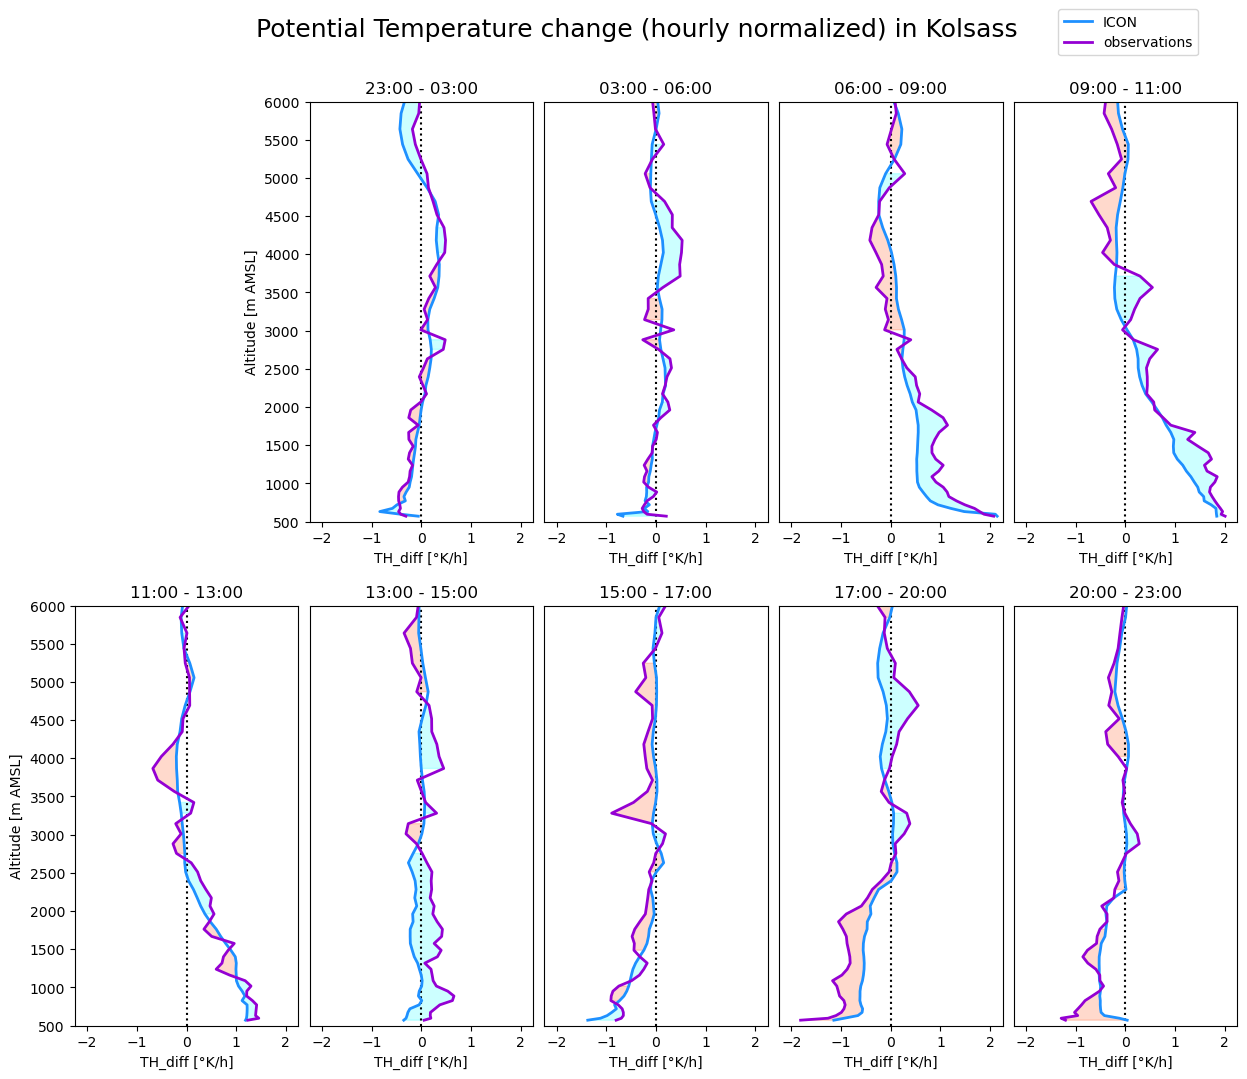

In [27]:
## PLOT ALL PROFILES DIFFERENCIES ##
# settings
cvar = vf.TH
pvar = vf.TH_diff
xmin=-2.25
xmax=2.25

ymin=500
ymax=6000

## COMPUTE THE TENDENCIES BETWEEN RS ##
# diffname = pvar.name+'_diff'
plotdates_model_list = list(plotdates_model)
htd_data_model['kols'][pvar.name] = np.empty((len(plotdates_model_list),73))
htd_data_kolsrs_interp[pvar.name] = np.empty((10,73))

for now in range(1,10):
    # dates
    pdate_now = plotdates_rs[now]
    pdate_before = plotdates_rs[now-1]
    delt=pdate_now-pdate_before
    # model
    sounding_model_now = np.array(htd_data_model['kols'][cvar.name][plotdates_model_list.index(pdate_now),:][0:73])
    sounding_model_before = np.array(htd_data_model['kols'][cvar.name][plotdates_model_list.index(pdate_before),:][0:73])
    htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_now)] = (sounding_model_now-sounding_model_before)/(delt.seconds/3600)
     
    # rs
    sounding_rs_interp_now = np.array(htd_data_kolsrs_interp[cvar.name][now,:])
    sounding_rs_interp_before = np.array(htd_data_kolsrs_interp[cvar.name][now-1,:])
    htd_data_kolsrs_interp[pvar.name][now] = (sounding_rs_interp_now - sounding_rs_interp_before)/(delt.seconds/3600)

## PLOT ##
# plots
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2,wspace=0.05)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.95)
for index, ax in enumerate(axes.ravel()):
    pdate = plotdates_rs[index]
    plot_sounding(pvar, pdate,lf.kols, ax)
    # x
    xdelticks=5
    ax.set_xlim([xmin,xmax])
    ax.set_xlabel(pvar.name+' '+pvar.units)
    # ax.set_xticklabels(['',285,290,295,''])
    # y
    ydelticks=500
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel(None)
    ax.set_yticks([])
    ax.vlines(0,ymin,ymax,colors='k', linestyles='dotted')
    ax.set_title(plotdates_rs[index-1].strftime('%H:%M')+' - '+pdate.strftime('%H:%M'), fontsize=12)
# set y ticks to left plot
f.delaxes(axes[0,0])
axes[0,1].set_ylabel('Altitude [m AMSL]')
axes[0,1].set_yticks(np.arange(ymin,ymax+1,ydelticks))
axes[1,0].set_ylabel('Altitude [m AMSL]')
axes[1,0].set_yticks(np.arange(ymin,ymax+1,ydelticks))
plt.legend(loc=(0.2,2.31))
plt.show()